In [107]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import glob
import scipy.stats as stats
from matplotlib.colors import LogNorm, SymLogNorm
from dataclasses import dataclass
import matplotlib
from mpl_toolkits.axes_grid1 import AxesGrid

In [108]:
path = "/home/cluster/hlasco/bulk1/turbulence/compressible/validation"
sim_list = sorted(glob.glob(path + "/mach_*/"))
mach_list = [int(m[-3:-1]) for m in sim_list]
for i in range(len(mach_list)):
    sim_list[i] = glob.glob(sim_list[i] + "*/processed_data/snapshot.h5")
    if sim_list[i] == []:
        mach_list.pop(i)
try:
    sim_list.remove([])
except:
    pass
print(mach_list)

[1, 2, 3, 4, 6, 8, 10, 12, 16, 20, 24, 28]


In [109]:
@dataclass
class turb_fields:
    mach: float
    ux: np.array(float)
    uy: np.array(float)        
    uz: np.array(float)        
    s:  np.array(float)        
    k:  np.array(float)        
    Es: np.array(float)
    Ec: np.array(float)
    E:  np.array(float)
    P:  np.array(float)
    att: dict()


In [188]:
def readSnapshot(file, mach, res='HR'):
    with h5.File(file[0], 'r') as f:
        att = dict(f[res].attrs)
        sim = f[res]
        k = np.array(sim['k'])
        P = np.array(sim['P'])
        Es = np.array(sim['Es'])
        Ec = np.array(sim['Ec'])
        E = Es + Ec
        
        ux = np.array(sim['ux'])
        uy = np.array(sim['uy'])
        uz = np.array(sim['uz'])
        s = np.array(sim['s'])
    return turb_fields(mach, ux, uy, uz, s, k, Es, Ec, E, P, att)

In [468]:
tf_list_hr = [readSnapshot(sim_list[i], mach_list[i], res='HR') for i in range(len(mach_list))]
tf_list_lr = [readSnapshot(sim_list[i], mach_list[i], res='LR') for i in range(len(mach_list))]
tf_list_filt = [readSnapshot(sim_list[i], mach_list[i], res='FILT') for i in range(len(mach_list))]

In [469]:
def grad(inpt, axis):
    dx = 1.0/inpt.shape[1]
    ret = np.gradient(inpt, dx, axis=axis)
    return ret

def get_velocity_grad(f):
    
    dudx = grad(f.ux,0)
    dudy = grad(f.ux,1)
    dudz = grad(f.ux,2)
    dvdx = grad(f.uy,0)
    dvdy = grad(f.uy,1)
    dvdz = grad(f.uy,2)
    dwdx = grad(f.uz,0)
    dwdy = grad(f.uz,1)
    dwdz = grad(f.uz,2)

    return dudx, dvdx, dwdx, dudy, dvdy, dwdy, dudz, dvdz, dwdz

def get_vorticity(f):
    dudx, dvdx, dwdx, dudy, dvdy, dwdy, dudz, dvdz, dwdz = get_velocity_grad(f)
    vort_x = dwdy - dvdz
    vort_y = dudz - dwdx
    vort_z = dvdx - dudy
    return np.stack((vort_x, vort_y, vort_z))

In [470]:
def get_ks(k,E, cs):
    E_ls = .5*cs**2
    
    sum_E = [np.sum(E[i:]) for i in range(len(k))]
    diff_E = np.fabs(np.array(sum_E) - E_ls)
    return k[np.argmin(diff_E)]
    

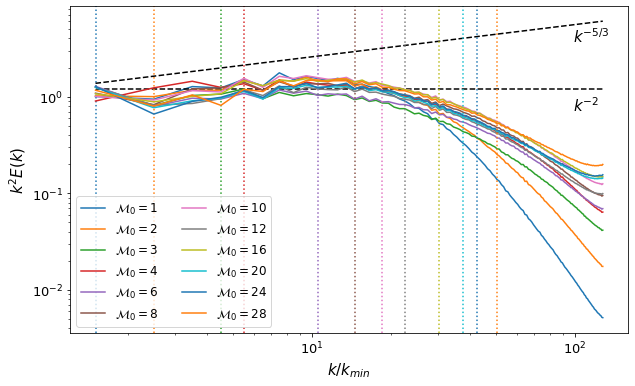

In [471]:
m = 2
plt.figure(figsize=(10,6))
cs = 0.18656300264905473
for i, f in enumerate(tf_list_hr):
    ks = get_ks(f.k, f.E, cs)
    y = f.k**m * f.E
    y = y / np.sum(f.E)
    plt.loglog(f.k, y, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))

    plt.axvline(x=ks, color='C{}'.format(i), linestyle=':')
    if i==0:
        plt.loglog(f.k, 1.2*(f.k)**(m-2), 'k--')
        plt.loglog(f.k, 1.2*(f.k)**(m-5./3), 'k--')
        plt.text(f.k[-30], (.7*(f.k)**(m-2))[-30], r'$k^{-2}$', fontsize=15)
        plt.text(f.k[-30], (.8*(f.k)**(m-5./3))[-30], r'$k^{-5/3}$', fontsize=15)
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$k^{2} E(k)$', fontsize=15)
plt.xlabel('$k / k_{min}$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

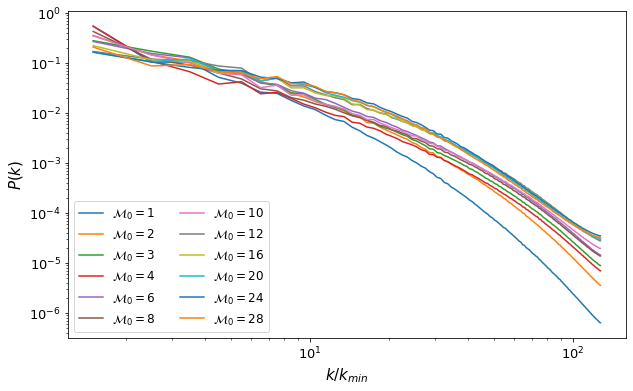

In [472]:
m = 0
plt.figure(figsize=(10,6))
for i, f in enumerate(tf_list_hr):
    y = f.k**m * f.P
    y = y / np.sum(f.P)
    plt.loglog(f.k, y, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$P(k)$', fontsize=15)
plt.xlabel('$k / k_{min}$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

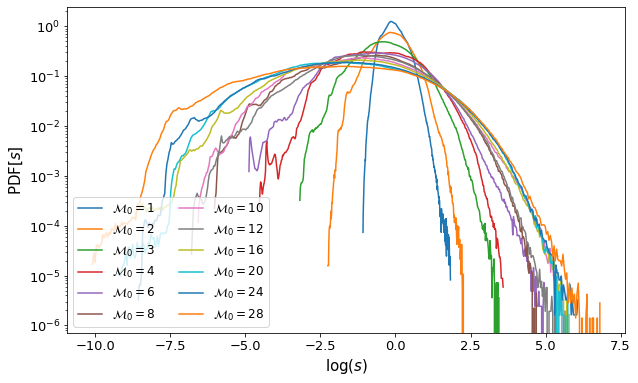

In [473]:
plt.figure(figsize=(10,6))
nBins = 400
for i, f in enumerate(tf_list_hr):
    s = f.s
    hist, bin_edges = np.histogram(s, density=True, bins=nBins)
    bins = .5*(bin_edges[1:] + bin_edges[:-1])
    plt.semilogy(bins, hist, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel(r'$\mathrm{PDF}[s]$', fontsize=15)
plt.xlabel(r'$\mathrm{log}(s)$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

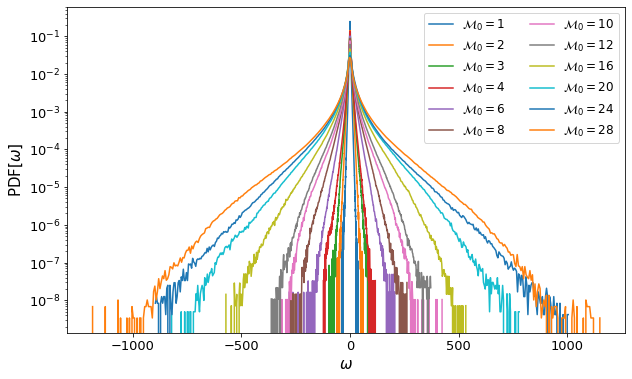

In [475]:
plt.figure(figsize=(10,6))
nBins = 400
for i, f in enumerate(tf_list_hr):
    w = get_vorticity(f)
    hist, bin_edges = np.histogram(w, density=True, bins=nBins)
    bins = .5*(bin_edges[1:] + bin_edges[:-1])
    plt.semilogy(bins, hist, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$\mathrm{PDF}[\omega]$', fontsize=15)
plt.xlabel('$\omega$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=1, ncol=2)
plt.show()

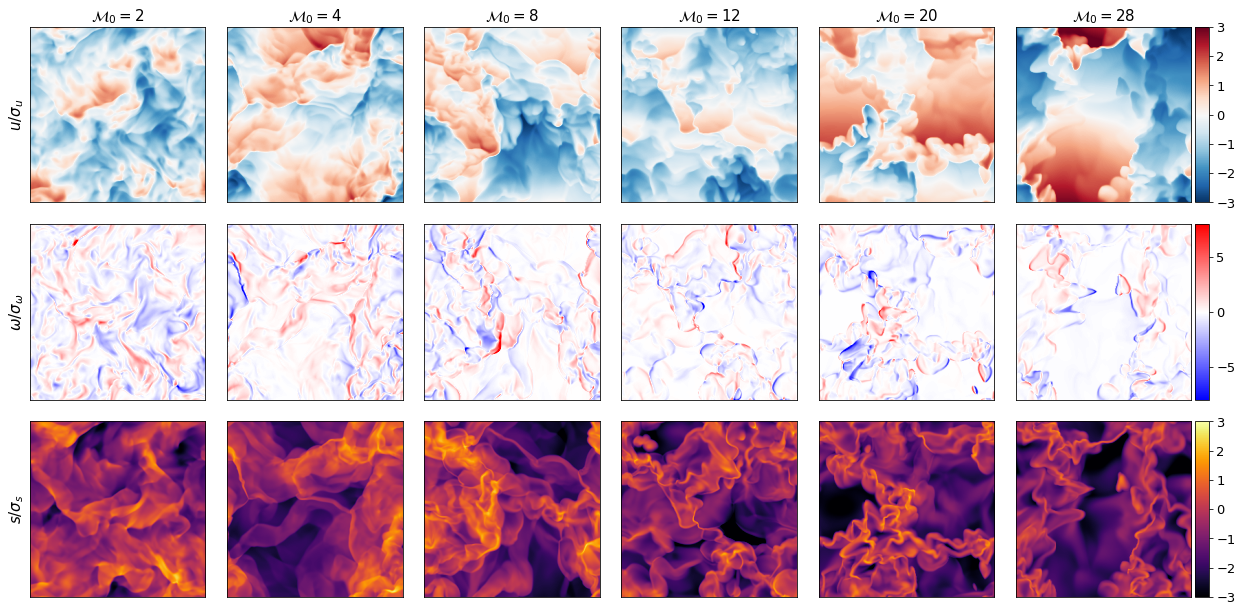

In [484]:
matplotlib.rcParams['mpl_toolkits.legacy_colorbar'] = False
params = matplotlib.figure.SubplotParams(left=.01, right=0.92, bottom=0.03, top=0.95)
skip=2
ncols=len(tf_list[1::skip])
nrows=3
fig = plt.figure(1, (6*nrows, 4*ncols), subplotpars=params)

grid = AxesGrid(fig, 111, nrows_ncols = (nrows, ncols), 
                axes_pad=0.3, cbar_mode='edge', cbar_size=.2,cbar_pad=.05)

for i, f in enumerate(tf_list_hr[1::skip]):
    
    grid[i].set_title(r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), fontsize=15)
    
    w = get_vorticity(f)

    sdev_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mean_vel = f.att['ux_mean'] + f.att['uy_mean'] + f.att['uz_mean']
    u = (f.ux[:,:,0]-mean_vel)/sdev_vel
    
    sdev_w = np.std(w)
    w = w[0,:,:,0]/sdev_w
    
    s = f.s
    sdev_s = f.att['s_std2']**.5
    s = s[:,:,0]/sdev_s

    im1 = grid[i].imshow(u, cmap='RdBu_r',vmin=-3, vmax=3)
    im2 = grid[i+ncols].imshow(w, cmap='bwr',vmin=-8, vmax=8) 
    im3 = grid[i+2*ncols].imshow(s, cmap='inferno',vmin=-3, vmax=3)
    
for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

grid[0].set_ylabel(r"$u / \sigma_{u}$", fontsize=15)
grid[ncols].set_ylabel(r"$\omega / \sigma_{\omega}$", fontsize=15)
grid[2*ncols].set_ylabel(r"$s / \sigma_{s}$", fontsize=15)

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[0].tick_params(labelsize=13) 
grid.cbar_axes[1].colorbar(im2)
grid.cbar_axes[1].tick_params(labelsize=13)
grid.cbar_axes[2].colorbar(im3)
grid.cbar_axes[2].tick_params(labelsize=13)
plt.show()

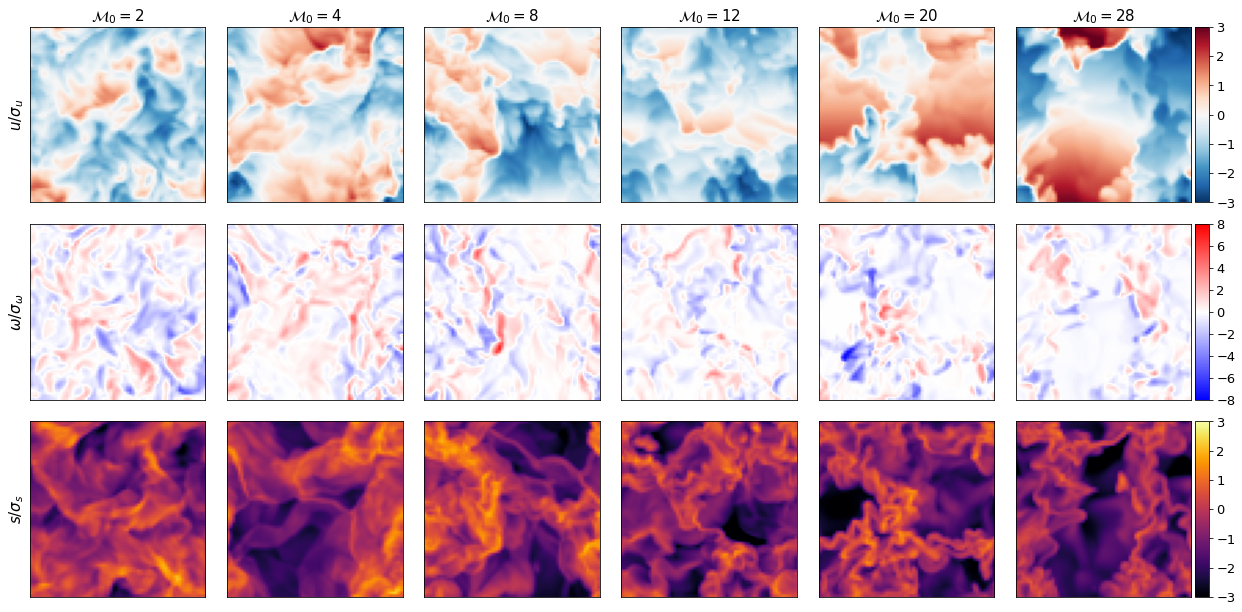

In [485]:
matplotlib.rcParams['mpl_toolkits.legacy_colorbar'] = False
params = matplotlib.figure.SubplotParams(left=.01, right=0.92, bottom=0.03, top=0.95)
skip=2
ncols=len(tf_list[1::skip])
nrows=3
fig = plt.figure(1, (6*nrows, 4*ncols), subplotpars=params)

grid = AxesGrid(fig, 111, nrows_ncols = (nrows, ncols), 
                axes_pad=0.3, cbar_mode='edge', cbar_size=.2,cbar_pad=.05)

for i, f in enumerate(tf_list_filt[1::skip]):
    
    grid[i].set_title(r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), fontsize=15)
    
    w = get_vorticity(f)

    sdev_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mean_vel = f.att['ux_mean'] + f.att['uy_mean'] + f.att['uz_mean']
    u = (f.ux[:,:,0]-mean_vel)/sdev_vel
    
    sdev_w = np.std(w)
    w = w[0,:,:,0]/sdev_w
    
    s = f.s
    sdev_s = f.att['s_std2']**.5
    s = s[:,:,0]/sdev_s

    im1 = grid[i].imshow(u, cmap='RdBu_r',norm=MidpointNormalize(-3, 3, 0.))
    im2 = grid[i+ncols].imshow(w, cmap='bwr',norm=MidpointNormalize(-8, 8, 0.)) 
    im3 = grid[i+2*ncols].imshow(s, cmap='inferno',norm=MidpointNormalize(-3, 3, 0.)) 
    
for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

grid[0].set_ylabel(r"$u / \sigma_{u}$", fontsize=15)
grid[ncols].set_ylabel(r"$\omega / \sigma_{\omega}$", fontsize=15)
grid[2*ncols].set_ylabel(r"$s / \sigma_{s}$", fontsize=15)

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[0].tick_params(labelsize=13) 
grid.cbar_axes[1].colorbar(im2)
grid.cbar_axes[1].tick_params(labelsize=13)
grid.cbar_axes[2].colorbar(im3)
grid.cbar_axes[2].tick_params(labelsize=13)
plt.show()

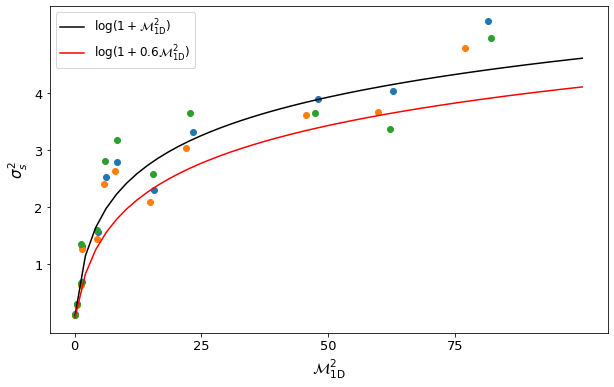

In [483]:
plt.figure(figsize=(10,6))
nBins = 400
for i, f in enumerate(tf_list_hr):
    sigma_s2 = f.att['s_std2']
    
    sigma_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mach2 = (sigma_vel/cs)**2
    plt.scatter(mach2, sigma_s2, color='C0')
    
for i, f in enumerate(tf_list_filt):
    sigma_s2 = f.att['s_std2']
    
    sigma_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mach2 = (sigma_vel/cs)**2
    plt.scatter(mach2, sigma_s2, color='C1')
    
for i, f in enumerate(tf_list_lr):
    sigma_s2 = f.att['s_std2']
    
    sigma_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mach2 = (sigma_vel/cs)**2
    plt.scatter(mach2, sigma_s2, color='C2')

x = np.linspace(.1,100)
y1 = np.log(1 + x)
y2 = np.log(1 + .6*x)
plt.plot(x,y1, color='k', label=r'$\mathrm{log} (1+ \mathcal{M}_\mathrm{1D}^2)$')
plt.plot(x,y2, color='r', label=r'$\mathrm{log} (1+ 0.6\mathcal{M}_\mathrm{1D}^2)$')
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma_s^2$', fontsize=15)
plt.xlabel(r'$\mathcal{M}_\mathrm{1D}^2$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.xticks([0,25,50,75])
plt.yticks([1,2,3,4])

plt.show()

In [427]:
snap = "/home/cluster/hlasco/bulk1/turbulence/incompressible/HITDNS03RK_UW_CFL010_BPD32_EXT2pi_RE205/vel_restart_000214267.h5"

In [428]:
with h5.File(snap, 'r') as f:
    print(f.keys())
    vel = np.array(f['data'])
    print(vel.shape)

<KeysViewHDF5 ['data', 'vx', 'vy', 'vz']>
(512, 512, 512, 3)
